In [29]:
import pandas as pd
import json
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from scipy.stats import gaussian_kde
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sbn
from scipy import stats

In [2]:
%matplotlib inline

In [3]:
# Load strain genotypes
with open("../Data/Mutation_data/Strain_to_genes.json") as infile:
    genotypes = json.load(infile)
genotypes["MG1655"] = set()

In [4]:
# Load cross tolerance and M9 growth rates
growth_data = pd.read_csv("../Data/Growth_data/Cross_tolerance/Cleaned_growth_rates.tsv", sep="\t", index_col=0)
growth_data = growth_data[growth_data["strain"].isin(genotypes)]  # Filter hypermutators out

m9_data = pd.read_csv("../Data/Growth_data/M9/M9_normalised_growth.csv")
m9_data = m9_data[m9_data["strain"].isin(genotypes)]  # Filter hypermutators out

In [5]:
df = pd.concat([growth_data, m9_data])
del df["exp_name"]
del df["tOD1"]

compounds = {"adipate": "ADIP",
            "hexanoate": "HEXA",
            "glutarate": "GLUT",
            "HMDA": "HMDA",
            "1,2-propanediol": "12PD",
            "2,3-butanediol": "23BD",
            "octanoate": "OCTA",
            "butanol": "BUT",
            "putrescine": "PUTR",
            "isobutyrate": "IBUA",
            "coumarate": "COUM"}

reverse_compounds = {value[0:3]: key for key, value in compounds.items()}

def strain_to_compound(strain):
    if strain == "MG1655":
        return None
    else:
        return reverse_compounds[strain[:3]]
    
df["evolved_compound"] = df["strain"].map(strain_to_compound)

In [6]:
short_df = df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "growth_rate")
rel_short_df = df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "rel_growth_rate")
min_rate, max_rate = np.nanmin(short_df.values), np.nanmax(short_df.values)
short_df["evolved_compound"] = short_df.index.map(strain_to_compound)
rel_short_df["evolved_compound"] = rel_short_df.index.map(strain_to_compound)

## Make cross-tolerance heat map

In [7]:
def prettify(string):
    if string == string.lower():
        return string.capitalize()
    else:
        return string

def lprettify(l):
    return [prettify(_) for _ in l]


def two_color_func(val):
    """
    Blue is higher, red is lower. 0 is white.
    """
    a = 240
    assert -1 <= val <= 1, val
    if val <= 0:
        val = -val
        #val = val**1.2
        red = a + (255-a)*val
        green = a - (a*0.9)*val #+ (150-a)*val
        blue = a - (a*0.9)*val #+ (150-a)*val
    else:
        #val = val**1.2
        red = a - (a*0.8)*val
        green = a - (a*0.8)*val
        blue = a + (255-a)*val
    col = "#%2.2x%2.2x%2.2x" % (int(red), int(green), int(blue))
    return col


def cat_dot_plot(df, color_df=None, fig=None, legend_min="", legend_max=""):
    plot_df = df.copy()
    min_size = 0.08
    max_size = 1
    plot_df = plot_df - plot_df.values.min() + 0.08
    plot_df = plot_df / plot_df.values.max() * 0.75
    if color_df is None:
        color_df = plot_df
    else:
        color_df = color_df.copy()
    x_cats = list(df)
    y_cats = list(df.index)
    
    if fig is None:
        fig = figure(x_range=lprettify(x_cats)+[""]*2, y_range=lprettify(y_cats), width=int(1000*1.3), height=int(850*1.3))
    
    fig.quad(left=0.5, right=2.5, bottom=9.5, top=11.48, color="#e2e2e2")
    fig.quad(left=2.5, right=4.5, bottom=7.5, top=9.5, color="#e2e2e2")
    fig.quad(left=4.5, right=6.5, bottom=5.5, top=7.5, color="#e2e2e2")
    fig.quad(left=6.5, right=8.5, bottom=3.5, top=5.5, color="#e2e2e2")
    fig.line([0, 11.4], [12, 0.6], color="darkblue", line_alpha=0.4)
    
    xs = []
    ys = []
    sizes = []
    colors = []
    for i, y in enumerate(y_cats):
        for j, x in enumerate(x_cats):
            xs.append(j + 1)
            ys.append(i + 1)
            circle_size = np.sqrt(plot_df.iloc[i, j]) / 2 * 1.2
            sizes.append(circle_size)
            colors.append(two_color_func(color_df.iloc[i, j]))
    fig.circle(xs, ys, radius=sizes, color=colors, line_color="#666666", line_width=0.5)
    #fig.text(xs, ys, sizes)
    
    # Add color legend
    leg_pos = (15, 7)
    reso = 50
    mini = color_df.values.min()
    maxi = color_df.values.max()
    color_ran = np.linspace(mini, maxi, reso)
    leg_height = 3
    for i in range(reso):
        fig.rect(
            x=leg_pos[0]-0.5,
            y=leg_pos[1]+leg_height/float(reso)*i,
            height=leg_height/float(reso),
            width=1,
            color=two_color_func(color_ran[i])
        )
    fig.text(
        x=[leg_pos[0]-1.4, leg_pos[0]-1.3],
        y=[leg_pos[1]-0.5, leg_pos[1]-0.3+leg_height+0.5],
        text=[str(round(legend_min, 2)) + " /h", str(round(legend_max, 2)) + " /h"],
        text_font_size="30px"
    )

    fig.line([len(x_cats)+0.55, len(x_cats)+0.55], [0, len(y_cats)+1], color="black", line_width=0.1)
    
    fig.xaxis.major_label_orientation = 1
    fig.grid.grid_line_color = None
    return fig

In [8]:
index_order = [
    "HMDA", "putrescine", "1,2-propanediol", "2,3-butanediol",
    "glutarate", "adipate", "hexanoate", "octanoate", "isobutyrate", "coumarate",
    "butanol",
    "None (MG1655)"]
    #"glutarate", "adipate", "hexanoate", "octanoate", "isobutyrate", "coumarate", "None (MG1655)"]

column_order = [
    "HMDA", "putrescine", "1,2-propanediol", "2,3-butanediol",
    "glutarate", "adipate", "hexanoate", "octanoate", "isobutyrate", "coumarate",
    "butanol",
    "NaCl"]
    #"glutarate", "adipate", "hexanoate", "octanoate", "isobutyrate", "coumarate", "NaCl"]

heatmap_df = short_df.copy()
heatmap_df.loc["MG1655", "evolved_compound"] = "None (MG1655)"
heatmap_df = heatmap_df.groupby("evolved_compound").mean()
heatmap_df = heatmap_df.reindex(index_order[::-1])[column_order]
heatmap_df["M9"] = df[df["grown_compound"] == "M9"].fillna("None (MG1655)").groupby("evolved_compound").mean()["growth_rate"]
#heatmap_df = np.log(heatmap_df)

std_df = short_df.copy()
std_df.loc["MG1655", "evolved_compound"] = "None (MG1655)"
std_df = std_df.groupby("evolved_compound").std()
std_df = std_df.reindex(index_order[::-1])[column_order]
std_df["M9"] = df[df["grown_compound"] == "M9"].fillna("None (MG1655)").groupby("evolved_compound").std()["growth_rate"]

def percentile_func(ser, q):
    # print(ser.columns)
    #ser = ser[pd.notnull(ser)]
    return pd.Series({c: np.nanpercentile(ser[c], q) for c in ser if c != "evolved_compound"})

q3_df = short_df.copy()
q3_df.loc["MG1655", "evolved_compound"] = "None (MG1655)"
q3_df = q3_df.groupby(["evolved_compound"]).apply(percentile_func, 75)
q3_df = q3_df.reindex(index_order[::-1])[column_order]
q3_df["M9"] = df[df["grown_compound"] == "M9"].fillna("None (MG1655)")[["evolved_compound", "growth_rate"]].groupby(
    "evolved_compound"
).apply(percentile_func, 75)["growth_rate"]

q1_df = short_df.copy()
q1_df.loc["MG1655", "evolved_compound"] = "None (MG1655)"
q1_df = q1_df.groupby(["evolved_compound"]).apply(percentile_func, 25)
q1_df = q1_df.reindex(index_order[::-1])[column_order]
q1_df["M9"] = df[df["grown_compound"] == "M9"].fillna("None (MG1655)")[["evolved_compound", "growth_rate"]].groupby(
    "evolved_compound"
).apply(percentile_func, 25)["growth_rate"]

In [9]:
normalisation_means = heatmap_df.loc["None (MG1655)", :]
color_df = (heatmap_df - normalisation_means)
print(color_df.values.min(), color_df.values.max())
legend_min, legend_max = color_df.values.min(), color_df.values.max()

color_df /= max(abs(color_df.values.max()), abs(color_df.values.min()))

heatmap_df = heatmap_df[1:]
std_df = std_df[1:]
color_df = color_df[1:]
q1_df = q1_df[1:]
q3_df = q3_df[1:]

-0.28770755661 0.3793892026


In [10]:
comp_to_shorthand = {k: v for k, v in compounds.items()}
comp_to_shorthand["M9"] = "M9"
comp_to_shorthand["NaCl"] = "NaCl"

8.8
10.4


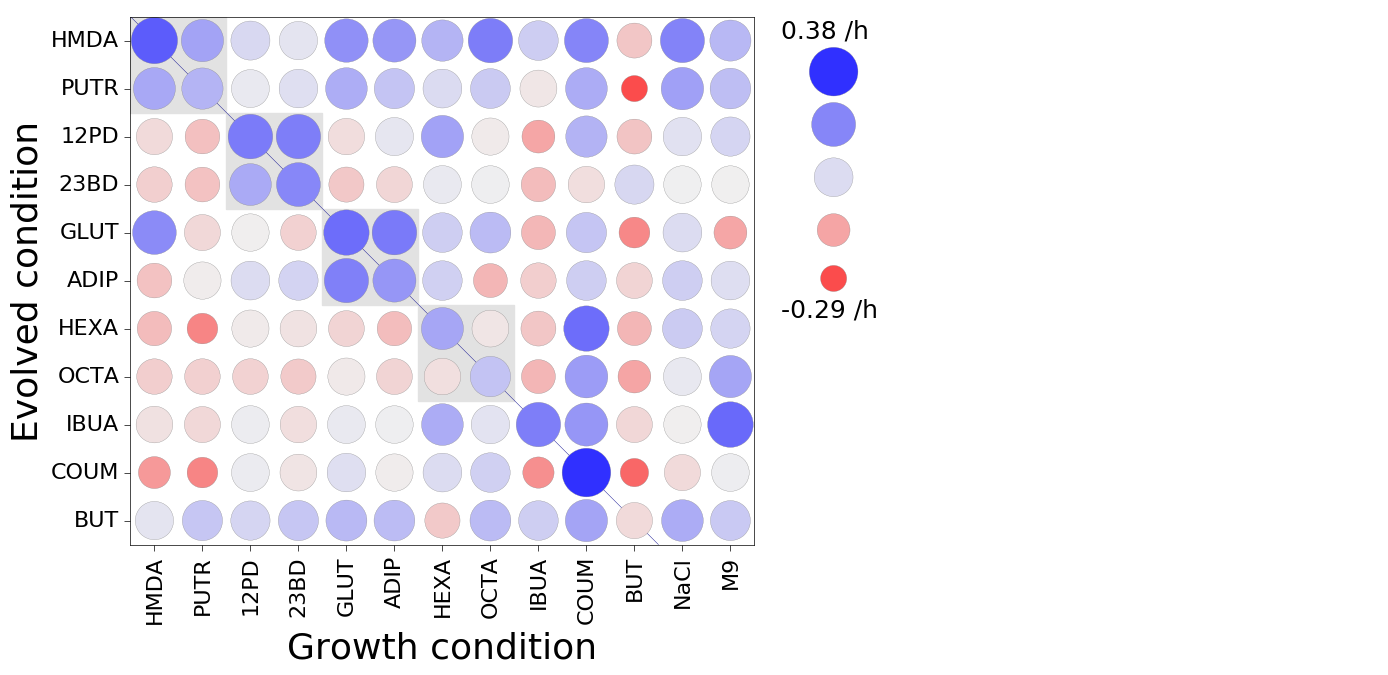

In [11]:
mpl.rcParams['pdf.fonttype'] = 42

num_cols = 13
num_rows = 11

size = 4
scale = 0.2

# The size of the figure in inches
height = size * scale * num_rows
width = size * scale * num_cols
print(height)
print(width)

# Make the figure
fig = plt.figure(figsize=[width, height], dpi=500)

# We need some space in the margins for labels. To keep space for the legend and keep the aspect ratio
# we add margins to all 4 sides
margin = 0.2
ax1 = fig.add_axes([margin, margin, 1-2*margin, 1-2*margin])
ax2 = fig.add_axes([1-margin, margin, 1-2*margin, 1-2*margin])

# Hide the axes for the legend part of the plot
ax2.axis("off")

# Normalize the data df
plot_df = heatmap_df - normalisation_means
upper_df = q3_df - normalisation_means #plot_df + std_df
lower_df = q1_df - normalisation_means #plot_df - std_df
min_size = 0.08
max_size = 1

max_value = upper_df.values.max()
min_value = lower_df.values.min()

min_size = 0.1
max_size = 0.9

scaling_slope = (max_size - min_size) / (max_value - min_value)
scaling_intercept = max_size - scaling_slope * max_value

plot_df =  plot_df  * scaling_slope + scaling_intercept
lower_df = lower_df * scaling_slope + scaling_intercept
upper_df = upper_df * scaling_slope + scaling_intercept


x_cats = list(plot_df)
y_cats = list(plot_df.index)

# Make white background
ax1.add_artist(plt.Rectangle((-0.5, -0.5), num_cols, num_rows, color="white", zorder=-1))

# Make the gray compound category rectangles
for i in [0, 2, 4, 6]:
    rect = plt.Rectangle((i-0.5, 8.5-i), 2, 2, color="#e2e2e2", zorder=0)
    ax1.add_artist(rect)

# Make the diagonal line
ax1.plot([-0.5, 10.5], np.array([10.5, -0.5]), zorder=1, color="darkblue", linewidth=0.3)

# Draw all the circles
for y, y_cat in enumerate(y_cats):
    for x, x_cat in enumerate(x_cats):
        circle_size = np.sqrt(plot_df.iloc[y, x]) / 2 * 1.1
        color = two_color_func(color_df.iloc[y, x])
        
        circle = plt.Circle((x, y), circle_size, facecolor=color, edgecolor="grey", linewidth=0.2)
        ax1.add_artist(circle)


# Set the axis ranges
ax1.set_ylim([-0.5, num_rows-0.5])
ax1.set_xlim([-0.5, num_cols-0.5])

ax2.set_xlim([0, 13/11.])


# Set the ticks + labels
ax1.set_xticks(range(num_cols))
ax1.set_yticks(range(num_rows))
ax1.tick_params(top="off", right="off", direction="out")

tick_size = 16
ax1.set_xticklabels(map(comp_to_shorthand.get, x_cats), fontsize=tick_size, rotation=90)
ax1.set_yticklabels(map(comp_to_shorthand.get, y_cats), fontsize=tick_size)

# Set the axis labels
labelsize = 26
ax1.set_xlabel("Growth condition", fontsize=labelsize)
ax1.set_ylabel("Evolved condition", fontsize=labelsize)

# Make the "frame" of axes 1 thinner
[(i.set_linewidth(0.5), i.set_color("black")) for i in ax1.spines.values()]

# Add color legend
leg_pos = (0.05, 0.5)
reso = 48
mini = color_df.values.min()
maxi = color_df.values.max()
color_ran = np.linspace(mini, maxi, reso)
mini = plot_df.values.min()
maxi = plot_df.values.max()
size_ran = np.linspace(mini, maxi, reso)
leg_height = 0.4
leg_width = 0.10
for i in range(reso):
    pos_i = leg_pos + np.array([0, i*leg_height/float(reso)])
    #rect = plt.Rectangle(pos_i, leg_width, leg_height/reso, color=two_color_func(color_ran[i]))
    if i == 0 or (i+1) % int(reso // 4) == 0: # Add a size legend
        siz = np.sqrt(size_ran[i]) / 2 * 1. / 10
        color = two_color_func(color_ran[i])
        circ = plt.Circle(
            (pos_i[0]+0.1, pos_i[1]+0.004), siz, facecolor=color, edgecolor="grey", linewidth=0.2
        )
        ax2.add_artist(circ)
    #ax2.add_artist(rect)

poly = plt.Polygon(np.array([(2, 2), (3, 3), (5, 3), (5, 2)]))

legend_fontsize = 18
ax2.text(leg_pos[0], leg_pos[1]-0.07, str(round(legend_min, 2)) + " /h", fontsize=legend_fontsize)
ax2.text(leg_pos[0], leg_pos[1]+leg_height+0.06, str(round(legend_max, 2)) + " /h", fontsize=legend_fontsize)

plt.savefig("../Plots/Figure 3 - Cross compound plot.png", transparent=True)
plt.savefig("../Plots/Figure 3 - Cross compound plot.pdf", transparent=True)
plt.show()

## Make sameclass compounds plots

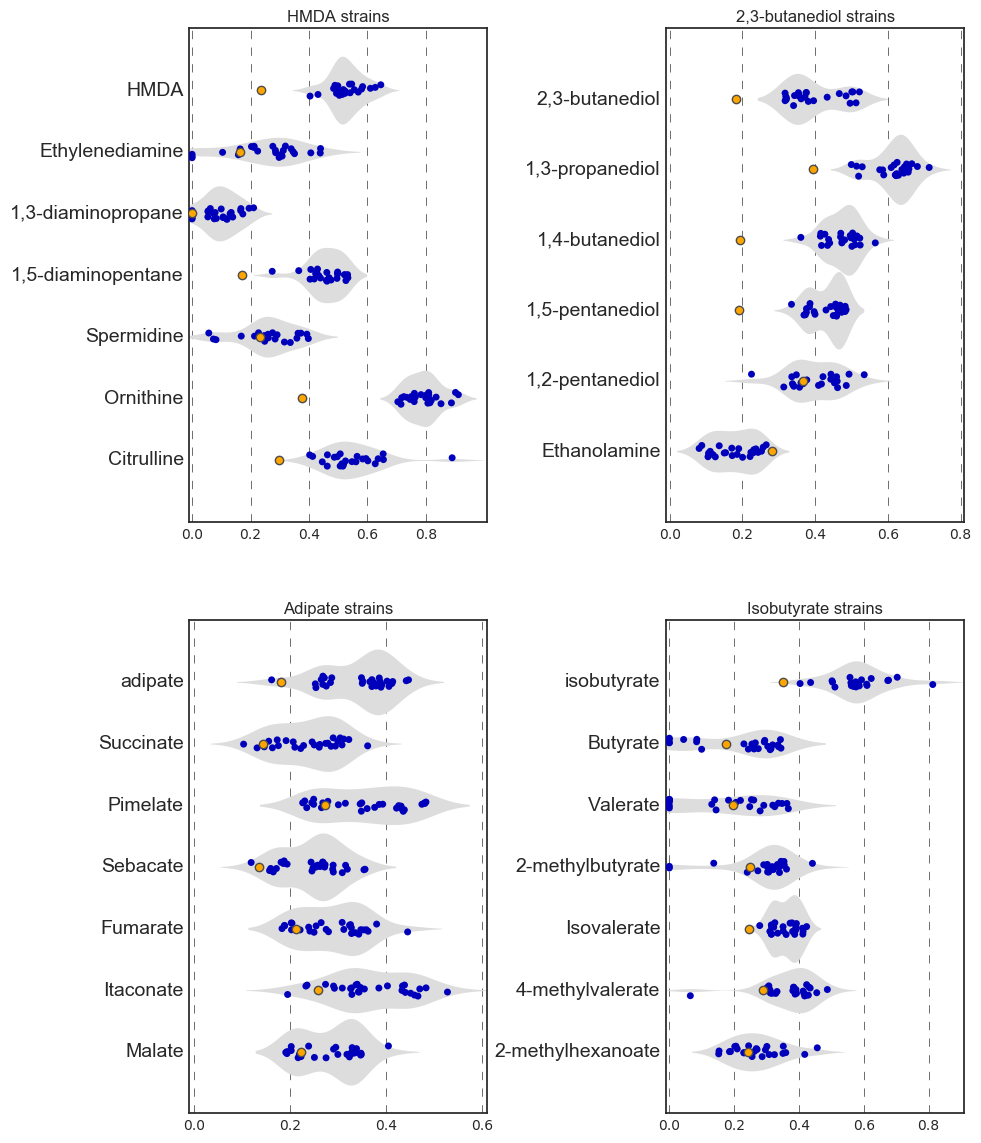

In [170]:
plt.style.use("seaborn-white")

fig = plt.figure(figsize=[10, 14])

compounds = {
    "HMDA": "HMDA",
    "23BD": "2,3-butanediol",
    "ADIP": "Adipate",
    "IBUA": "Isobutyrate"
}

xmin = -0.01
dif = 0.01

for i, c in enumerate(["HMDA", "23BD", "ADIP", "IBUA"]):
    plt.subplot(2, 2, i+1)
    
    plot_df = pd.read_csv("../Data/Growth_data/Sameclass-compounds/" + c + ".csv", index_col=0)
    plot_df.index.name = "strain"
    mg_df = plot_df[plot_df.index == "MG1655"]
    plot_df = plot_df[plot_df.index != "MG1655"]
    plot_df = pd.melt(plot_df.reset_index(), id_vars="strain")
    sbn.violinplot(
        y="variable", x="value", data=plot_df, orient="h", inner=None, color="#dddddd",
        linewidth=0, width=1.1
    )
    
    sbn.stripplot(
        y="variable", x="value", data=plot_df, orient="h", color="#0000bb",
        linewidth=0, size=5
    )
    
    sbn.swarmplot(
        y="variable", x="value", data=pd.melt(mg_df.reset_index(), id_vars="strain"),
        color="orange", linewidth=1, size=6
    )
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(axis="x", linestyle="--", color="#333333")
    plt.ylim([len(set(plot_df["variable"])), -1])
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8])
    if c == "HMDA":
        plt.xlim([xmin, 1+dif])
    elif c == "23BD":
        plt.xlim([xmin, 0.8+dif])
    elif c == "ADIP":
        plt.xlim([xmin, 0.6+dif])
    elif c == "IBUA":
        plt.xlim([xmin, 0.9+dif])
    else:
        raise RuntimeError()
    
    
    plt.title(compounds[c] + " strains")
    plt.yticks(fontsize=14)
    
plt.subplots_adjust(wspace=0.6)

## Make global tolerance plots

In [23]:
comp_name_order = [
    "1,2-propanediol", "2,3-butanediol", "HMDA", "putrescine", "glutarate",
    "adipate", "hexanoate", "octanoate", "coumarate", "isobutyrate", "butanol", "NaCl"
]

comp_order = ["12PD", "23BD", "HMDA", "PUTR", "GLUT", "ADIP", "HEXA", "OCTA", "COUM", "IBUA", "BUT"]

growth_df = pd.read_csv("../Data/Growth_data/Cross_tolerance/Cleaned_growth_rates.tsv", sep="\t")
long_growth_df = growth_df.copy()
growth_df = growth_df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "rel_growth_rate")[comp_name_order]
raw_growth_df = long_growth_df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "growth_rate")


m9_growth = pd.read_csv("../Data/Growth_data/M9/M9_normalised_growth.csv")
m9_growth = m9_growth[m9_growth["growth_rate"] != 0].groupby("strain").mean()

growth_df["M9"] = m9_growth["rel_growth_rate"]

In [25]:
def tol_metric(row):
        
    if pd.isnull(row["coumarate"]):
        coum = row[comp_name_order].mean()
    else:
        coum = row["coumarate"]
        
    if pd.isnull(row["isobutyrate"]):
        ibua = row[comp_name_order].mean()
    else:
        ibua = row["isobutyrate"]
    if "butanol" in row:
        if pd.isnull(row["butanol"]):
            but = row[comp_name_order].mean()
        else:
            but = row["butanol"]
    return (
        (
            row[["HMDA", "putrescine"]].mean() + 
            row[["glutarate", "adipate"]].mean() + 
            row[["hexanoate", "octanoate"]].mean()
        )
        + ibua + row["2,3-butanediol"] + coum + but
    )

(0.060975646249288751, 0.31016964020879501)
(0.52168309678663594, 5.1507952773385668e-21)


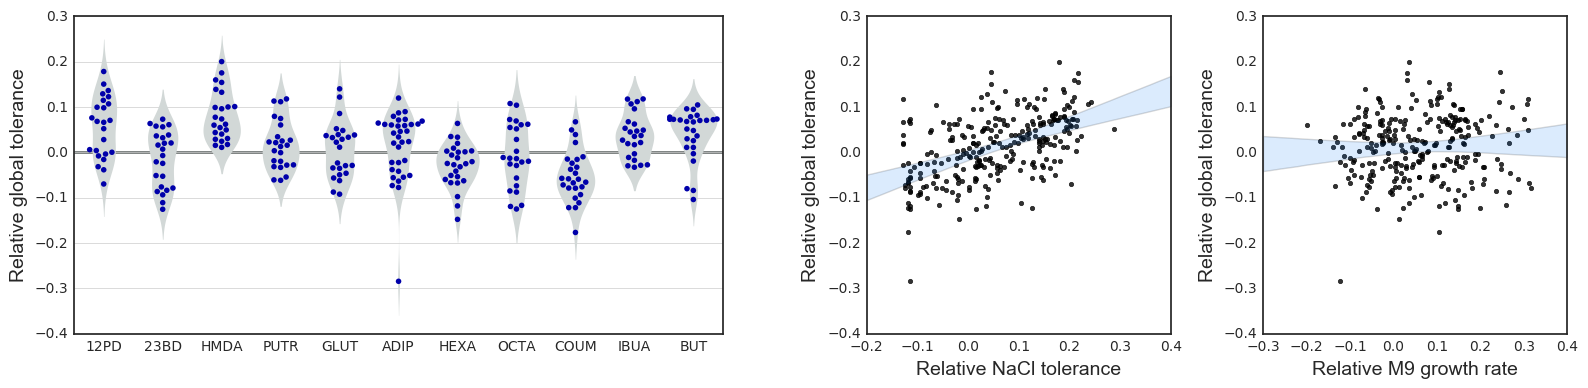

In [63]:
plt.style.use("seaborn-white")
plt.figure(figsize=[16, 4])

fs = 14

plot_df = growth_df.copy()
plot_df["global"] = plot_df.apply(tol_metric, axis=1) / 7
plot_df["comp"] = plot_df.index.map(lambda x: x.split("-")[0][:-1])
plot_df = plot_df[plot_df["comp"] != "MG165"]
plot_df = plot_df.reindex(sorted(plot_df.index, key=lambda x: comp_order.index(plot_df["comp"][x])))

plt.subplot(1, 2, 1)

plt.plot([-0.5, 10.5], [0, 0], zorder=-10, color="#727877", linewidth=2)
sbn.violinplot(x="comp", y="global", data=plot_df, inner=None, color="#d2d8d7", zorder=10, saturation=1, linewidth=0)
sbn.swarmplot(
    x="comp", y="global", data=plot_df,
    color="#0000aa",
    size=4, zorder=15
)
plt.xlabel("")
plt.grid(axis="y")
plt.ylabel("Relative global tolerance", fontsize=fs)


plt.subplot(1, 4, 4)
sbn.regplot(x="M9", y="global", data=plot_df, ci=99, n_boot=10000, line_kws={"alpha": 0, "color": "#0f7bf3"}, scatter_kws={"s": 10, "color": "black"})
plt.xlabel("Relative M9 growth rate", fontsize=fs)
plt.ylabel("Relative global tolerance", fontsize=fs)

pearson_df = plot_df[["M9", "global"]].dropna()
print(stats.pearsonr(pearson_df["M9"], pearson_df["global"]))

plt.subplot(1, 4, 3)
sbn.regplot(x="NaCl", y="global", data=plot_df, ci=99, n_boot=10000, line_kws={"alpha": 0.0, "color": "#0f7bf3"}, scatter_kws={"s": 10, "color": "black"})
plt.xlabel("Relative NaCl tolerance", fontsize=fs)
plt.ylabel("Relative global tolerance", fontsize=fs)

pearson_df = plot_df[["NaCl", "global"]].dropna()
print(stats.pearsonr(pearson_df["NaCl"], pearson_df["global"]))

plt.tight_layout()

# plt.savefig("../Plots/Figure 3d - Global tolerance correlations.pdf", transparent=True)